This notebook will guide you through training DCGAN with celeba dataset. The code is inspired mainly by https://github.com/YongWookHa/DCGAN-Keras repository.

[Aligned and cropped version](https://drive.google.com/drive/folders/0B7EVK8r0v71pTUZsaXdaSnZBZzg) of the [celeba dataset](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) was used in this notebook. 

# Data preparation

The training will be much faster if you run this notebook on GPU such as [colab](https://colab.research.google.com) environment. Since colab VM's are ephemeral and recycled after certain period of inactivity, it is best to load the data fresh into the colab's VM before training.

In the following code, it is assumed that celeba dataset is uploaded on your google drive as zip file. The zipfile is extracted inside the colab VM's file system. Reading the images directly from google drive results in [timeout](https://stackoverflow.com/questions/54294532/time-out-on-drive-mount-content-drive-in-google-colab), therefore was not possible. The celeba images are cropped using cropface.py in the same repo as this notebook.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!cp "/content/drive/My Drive/celeba/32by32.zip" .
!unzip -q 32by32.zip -d celeba

The following code is an implementation of a data loader that provides a random batch of training images from the given dataset. The data loader can be configured to load all images into the memory, this will be faster option for the training. On colab VM, loading around 180k celeba images into memory resulted in RAM usage of 5GB.

In [6]:
from glob import glob
import numpy as np
import cv2

class DataLoader():
    def __init__(self, dataset_name, img_res=(28, 28), mem_load=True, extension="jpg"):

        self.mem_load = mem_load
        self.dataset_name = dataset_name
        self.img_res = img_res
        self.path = glob(f"{self.dataset_name}/{self.img_res[0]}by{self.img_res[1]}/*.{extension}")
        self.n_data = len(self.path)
        if self.mem_load:
            # scale image RGB values from 0,255 to -1,1
            self.total_imgs = np.array(list(map(self.imread, self.path))) / 127.5 -1.

    def load_data(self, batch_size=1, is_testing=False):
        imgs = [] # images to be returned
        if self.mem_load:
            # return random batch from imgs loaded in memory
            idx = np.random.choice(range(self.n_data), size=batch_size)
            for i in idx:
                imgs.append(self.total_imgs[i])
            imgs = np.array(imgs)
        else:
            # read random batch of images
            batch_images = np.random.choice(self.path, size=batch_size)

            for img_path in batch_images:
                img = self.imread(img_path)
                imgs.append(img)

            # scale image RGB values from 0,255 to -1,1
            imgs = np.array(imgs) / 127.5 - 1.
        return imgs

    def get_n_data(self):
        return self.n_data

    def imread(self, path):
        img = cv2.imread(path)
        # cv2 reads image in BGR - convert to RGB to be compatible with matplotlib
        return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [7]:
# instantiate the data loader once here and load all images onto memory
dl = DataLoader(dataset_name = "celeba", img_res=(32,32), mem_load=True)

# DCGAN model


In [8]:
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import BatchNormalization, Activation, UpSampling2D, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2DTranspose, Conv2D
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard

import datetime
from time import localtime, strftime
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import tensorflow as tf

def make_trainable(net, val):
    net.trainable = val
    for l in net.layers:
        l.trainable = val

def time():
    return strftime('%m%d_%H%M', localtime())

class DCGAN():
    def __init__(self, dataset_name = "celeba", img_size = 32, channels = 3, backup_dir = "backup"):
        
        self.dataset_name = dataset_name
        self.img_size = img_size
        self.channels = channels
        
        self.backup_dir = backup_dir
        self.time = time()

        # Input shape
        self.latent_dim = 100
        self.learning_rate = 1e-3

        self.gf = 64 # filter size of generator's last layer
        self.df = 64 # filter size of discriminator's first layer

        optimizer_disc = Adam(self.learning_rate / 10, beta_1=0.5, decay=0.00005)
        optimizer_gen = Adam(self.learning_rate, beta_1=0.5, decay=0.00005)

        # Configure data loader
        self.dl = dl
        self.n_data = self.dl.get_n_data()

        # Build generator
        self.generator = self.build_generator()
        print("---------------------generator summary----------------------------")
        self.generator.summary()


        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        print("\n---------------------discriminator summary----------------------------")
        self.discriminator.summary()

        self.discriminator.compile(loss='binary_crossentropy',
                                   optimizer=optimizer_disc,
                                   metrics=['accuracy'])

        z = Input(shape=(self.latent_dim,))
        fake_img = self.generator(z)

        # for the combined model, we only train ganerator
        self.discriminator.trainable = False

        validity = self.discriminator(fake_img)

        # Build combined model
        self.combined = Model(z, validity)
        print("\n---------------------combined summary----------------------------")
        self.combined.summary()
        self.combined.compile(loss=['binary_crossentropy'],
                              optimizer=optimizer_gen)

    def build_generator(self):
        noise = Input(shape=(self.latent_dim,))

        def deconv2d(layer_input, filters=256, kernel_size=(5, 5), strides=(2, 2), bn_relu=True):
            """Layers used during upsampling"""
            u = Conv2DTranspose(filters, kernel_size=kernel_size, strides=strides, padding='same', use_bias=False)(layer_input)
            if bn_relu:
                u = BatchNormalization()(u)
                u = Activation("relu")(u)
                
            return u

        generator = Dense(4 * self.gf * self.img_size // 4 * self.img_size // 4, use_bias=False)(noise)
        generator = BatchNormalization()(generator)
        generator = Activation('relu')(generator)
        generator = Reshape((self.img_size // 4, self.img_size // 4, self.gf * 4))(generator)
        generator = deconv2d(generator, filters=self.gf * 2)
        generator = deconv2d(generator, filters=self.gf    )
        generator = deconv2d(generator, filters=self.channels, kernel_size=(3,3), strides=(1,1), bn_relu=False)

        generator = Activation('tanh')(generator)

        return Model(noise, generator)

    def build_discriminator(self):

        def d_block(layer_input, filters, strides=1, bn=True):
            """Discriminator layer"""
            d = Conv2D(filters, kernel_size=3, strides=strides, padding='same', use_bias=False)(layer_input)
            if bn:
                d = Dropout(rate=0.8)(d)
            d = LeakyReLU(alpha=0.2)(d)
            

            return d

        # Input img = generated image
        d0 = Input(shape=(self.img_size, self.img_size, self.channels))

        d = d_block(d0, self.df, strides=2, bn=False)
        d = d_block(d, self.df*2, strides=2)

        d = Flatten()(d)
        validity = Dense(1, activation='sigmoid')(d)

        return Model(d0, validity)

    def train(self, epochs, batch_size, sample_interval):
        def named_logs(model, logs):
            result = {}
            for l in zip(model.metrics_names, logs):
                result[l[0]] = l[1]
            return result

        start_time = datetime.datetime.now()

        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        max_iter = int(self.n_data/batch_size)
        os.makedirs(f"{self.backup_dir}/logs/{self.time}", exist_ok=True)
        tensorboard = TensorBoard(f"{self.backup_dir}/logs/{self.time}")
        tensorboard.set_model(self.generator)

        os.makedirs(f"{self.backup_dir}/models/{self.time}/", exist_ok=True)
        with open(f"{self.backup_dir}/models/{self.time}/generator_architecture.json", "w") as f:
            f.write(self.generator.to_json())
        print(f"\nbatch size : {batch_size} | num_data : {self.n_data} | max iteration : {max_iter} | time : {self.time} \n")
        for epoch in range(1, epochs+1):
            for iter in range(max_iter):
                # ------------------
                #  Train Generator
                # ------------------
                ref_imgs = self.dl.load_data(batch_size)

                noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
                gen_imgs = self.generator.predict(noise)
                make_trainable(self.discriminator, True)
                d_loss_real = self.discriminator.train_on_batch(ref_imgs, valid * 0.9)  # label smoothing *0.9
                d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

                make_trainable(self.discriminator, False)

                logs = self.combined.train_on_batch([noise], [valid])
                tensorboard.on_epoch_end(iter, named_logs(self.combined, [logs]))

                if iter % (sample_interval // 10) == 0:
                    elapsed_time = datetime.datetime.now() - start_time
                    print(f"epoch:{epoch} | iter : {iter} / {max_iter} | time : {elapsed_time} | g_loss : {logs} | d_loss : {d_loss} ")

                if (iter+1) % sample_interval == 0:
                    self.sample_images(epoch, iter+1)

            # save weights after every epoch
            self.generator.save_weights(f"{self.backup_dir}/models/{self.time}/generator_epoch{epoch}_weights.h5")

    def sample_images(self, epoch, iter):
        os.makedirs(f'{self.backup_dir}/samples/{self.time}', exist_ok=True)
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r*c, self.latent_dim))
        gen_img = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_img = 0.5 * gen_img + 0.5

        # Save generated images and the high resolution originals
        fig, axs = plt.subplots(r, c)
        for row in range(r):
            for col in range(c):
                axs[row, col].imshow(gen_img[5*row+col,:,:,:])
                axs[row, col].axis('off')
        fig.savefig(f"{self.backup_dir}/samples/{self.time}/e{epoch}-i{iter}.png", bbox_inches='tight', dpi=100)

        # use only when running in ipython, otherwise halts the execution
        plt.show()

        plt.close()

# Training

---------------------generator summary----------------------------
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
activation (Activation)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 128)       819200    
_____________________________________________________

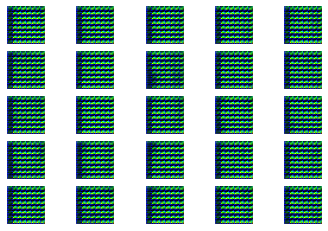

epoch:1 | iter : 100 / 2896 | time : 0:00:20.718924 | g_loss : 2.6437737941741943 | d_loss : [0.3070299 0.5      ] 
epoch:1 | iter : 110 / 2896 | time : 0:00:21.892504 | g_loss : 2.029158353805542 | d_loss : [0.34144289 0.5       ] 
epoch:1 | iter : 120 / 2896 | time : 0:00:23.059443 | g_loss : 1.2631323337554932 | d_loss : [0.54709047 0.3515625 ] 
epoch:1 | iter : 130 / 2896 | time : 0:00:24.202958 | g_loss : 1.1602129936218262 | d_loss : [0.6207948 0.4609375] 
epoch:1 | iter : 140 / 2896 | time : 0:00:25.351910 | g_loss : 0.25525256991386414 | d_loss : [0.39475847 0.5       ] 
epoch:1 | iter : 150 / 2896 | time : 0:00:26.560713 | g_loss : 0.09221543371677399 | d_loss : [0.39355919 0.5       ] 
epoch:1 | iter : 160 / 2896 | time : 0:00:27.724028 | g_loss : 0.04134432598948479 | d_loss : [0.3711761 0.5      ] 
epoch:1 | iter : 170 / 2896 | time : 0:00:28.893354 | g_loss : 0.03866903856396675 | d_loss : [0.40246548 0.5       ] 
epoch:1 | iter : 180 / 2896 | time : 0:00:30.063417 | g_los

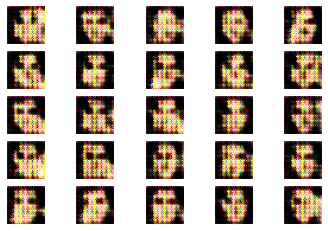

epoch:1 | iter : 200 / 2896 | time : 0:00:33.176267 | g_loss : 1.0451741218566895 | d_loss : [0.76351824 0.359375  ] 
epoch:1 | iter : 210 / 2896 | time : 0:00:34.346586 | g_loss : 0.4925619661808014 | d_loss : [0.73556858 0.4453125 ] 
epoch:1 | iter : 220 / 2896 | time : 0:00:35.503150 | g_loss : 0.3372896909713745 | d_loss : [0.75735103 0.4609375 ] 
epoch:1 | iter : 230 / 2896 | time : 0:00:36.666877 | g_loss : 0.11158530414104462 | d_loss : [0.63112678 0.4609375 ] 
epoch:1 | iter : 240 / 2896 | time : 0:00:37.811016 | g_loss : 0.10478448867797852 | d_loss : [0.64088774 0.484375  ] 
epoch:1 | iter : 250 / 2896 | time : 0:00:38.960235 | g_loss : 0.3118191361427307 | d_loss : [0.63055313 0.4375    ] 
epoch:1 | iter : 260 / 2896 | time : 0:00:40.141055 | g_loss : 0.45628300309181213 | d_loss : [0.54440239 0.484375  ] 
epoch:1 | iter : 270 / 2896 | time : 0:00:41.281810 | g_loss : 1.157741904258728 | d_loss : [0.74930662 0.3359375 ] 
epoch:1 | iter : 280 / 2896 | time : 0:00:42.432792 | 

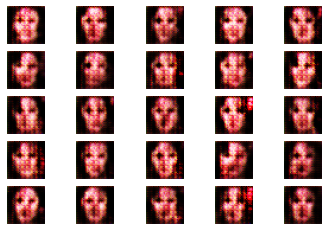

epoch:1 | iter : 300 / 2896 | time : 0:00:45.650437 | g_loss : 0.7604751586914062 | d_loss : [0.63665649 0.4921875 ] 
epoch:1 | iter : 310 / 2896 | time : 0:00:46.754300 | g_loss : 0.18190573155879974 | d_loss : [0.55920976 0.5       ] 
epoch:1 | iter : 320 / 2896 | time : 0:00:47.879434 | g_loss : 0.021664924919605255 | d_loss : [0.433345 0.5     ] 
epoch:1 | iter : 330 / 2896 | time : 0:00:48.991370 | g_loss : 0.006594556383788586 | d_loss : [0.40382122 0.5       ] 
epoch:1 | iter : 340 / 2896 | time : 0:00:50.114117 | g_loss : 0.006129580549895763 | d_loss : [0.48282933 0.5       ] 
epoch:1 | iter : 350 / 2896 | time : 0:00:51.240270 | g_loss : 0.021742817014455795 | d_loss : [0.5226832 0.4609375] 
epoch:1 | iter : 360 / 2896 | time : 0:00:52.367628 | g_loss : 0.9192625880241394 | d_loss : [0.61428958 0.4921875 ] 
epoch:1 | iter : 370 / 2896 | time : 0:00:53.523295 | g_loss : 0.2947869300842285 | d_loss : [0.61285062 0.453125  ] 
epoch:1 | iter : 380 / 2896 | time : 0:00:54.669634 |

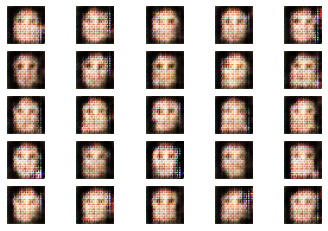

epoch:1 | iter : 400 / 2896 | time : 0:00:57.879308 | g_loss : 0.9458736777305603 | d_loss : [0.64141482 0.4921875 ] 
epoch:1 | iter : 410 / 2896 | time : 0:00:58.993268 | g_loss : 0.8049987554550171 | d_loss : [0.7490876 0.4375   ] 
epoch:1 | iter : 420 / 2896 | time : 0:01:00.086700 | g_loss : 0.6004666686058044 | d_loss : [0.62097938 0.5       ] 
epoch:1 | iter : 430 / 2896 | time : 0:01:01.189799 | g_loss : 0.030215254053473473 | d_loss : [0.44653371 0.5       ] 
epoch:1 | iter : 440 / 2896 | time : 0:01:02.296568 | g_loss : 0.005673825740814209 | d_loss : [0.33577838 0.5       ] 
epoch:1 | iter : 450 / 2896 | time : 0:01:03.399315 | g_loss : 0.003612642642110586 | d_loss : [0.32625479 0.5       ] 
epoch:1 | iter : 460 / 2896 | time : 0:01:04.514542 | g_loss : 0.0028077473398298025 | d_loss : [0.38562983 0.5       ] 
epoch:1 | iter : 470 / 2896 | time : 0:01:05.617748 | g_loss : 0.00403248518705368 | d_loss : [0.37293614 0.5       ] 
epoch:1 | iter : 480 / 2896 | time : 0:01:06.727

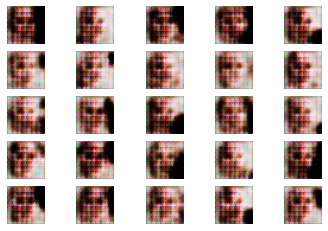

epoch:1 | iter : 500 / 2896 | time : 0:01:09.654519 | g_loss : 0.09348735213279724 | d_loss : [0.53494632 0.4296875 ] 
epoch:1 | iter : 510 / 2896 | time : 0:01:10.809335 | g_loss : 0.9100072979927063 | d_loss : [0.73890704 0.265625  ] 
epoch:1 | iter : 520 / 2896 | time : 0:01:11.946213 | g_loss : 0.07025200128555298 | d_loss : [0.34235698 0.5       ] 
epoch:1 | iter : 530 / 2896 | time : 0:01:13.097625 | g_loss : 0.02534412406384945 | d_loss : [0.2990522 0.5      ] 
epoch:1 | iter : 540 / 2896 | time : 0:01:14.219398 | g_loss : 0.01445658691227436 | d_loss : [0.27630405 0.5       ] 
epoch:1 | iter : 550 / 2896 | time : 0:01:15.351447 | g_loss : 0.012549087405204773 | d_loss : [0.28744634 0.5       ] 
epoch:1 | iter : 560 / 2896 | time : 0:01:16.477295 | g_loss : 0.012468996457755566 | d_loss : [0.37115049 0.4921875 ] 
epoch:1 | iter : 570 / 2896 | time : 0:01:17.616243 | g_loss : 0.017389416694641113 | d_loss : [0.51912206 0.484375  ] 
epoch:1 | iter : 580 / 2896 | time : 0:01:18.768

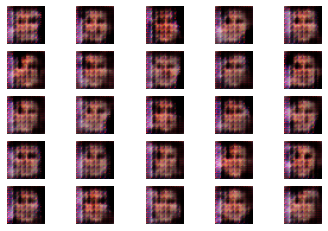

epoch:1 | iter : 600 / 2896 | time : 0:01:21.961169 | g_loss : 0.22722677886486053 | d_loss : [0.58364502 0.46875   ] 
epoch:1 | iter : 610 / 2896 | time : 0:01:23.052143 | g_loss : 0.015860706567764282 | d_loss : [0.326232 0.5     ] 
epoch:1 | iter : 620 / 2896 | time : 0:01:24.154397 | g_loss : 0.006059389095753431 | d_loss : [0.31675911 0.5       ] 
epoch:1 | iter : 630 / 2896 | time : 0:01:25.244362 | g_loss : 0.004593091085553169 | d_loss : [0.31285524 0.5       ] 
epoch:1 | iter : 640 / 2896 | time : 0:01:26.334597 | g_loss : 0.003939998801797628 | d_loss : [0.33311144 0.5       ] 
epoch:1 | iter : 650 / 2896 | time : 0:01:27.438519 | g_loss : 0.005631179548799992 | d_loss : [0.37494256 0.4921875 ] 
epoch:1 | iter : 660 / 2896 | time : 0:01:28.542487 | g_loss : 0.010919559746980667 | d_loss : [0.4096131 0.5      ] 
epoch:1 | iter : 670 / 2896 | time : 0:01:29.644659 | g_loss : 0.026039650663733482 | d_loss : [0.46884273 0.46875   ] 
epoch:1 | iter : 680 / 2896 | time : 0:01:30.75

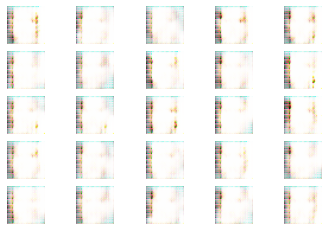

epoch:1 | iter : 700 / 2896 | time : 0:01:33.867628 | g_loss : 0.02472604624927044 | d_loss : [0.33459421 0.5       ] 
epoch:1 | iter : 710 / 2896 | time : 0:01:34.966926 | g_loss : 0.008917806670069695 | d_loss : [0.29922331 0.5       ] 
epoch:1 | iter : 720 / 2896 | time : 0:01:36.065375 | g_loss : 0.0076079582795500755 | d_loss : [0.25314393 0.5       ] 
epoch:1 | iter : 730 / 2896 | time : 0:01:37.184239 | g_loss : 0.00679193576797843 | d_loss : [0.28449896 0.5       ] 
epoch:1 | iter : 740 / 2896 | time : 0:01:38.290521 | g_loss : 0.006915383040904999 | d_loss : [0.26597447 0.5       ] 
epoch:1 | iter : 750 / 2896 | time : 0:01:39.393267 | g_loss : 0.006672130431979895 | d_loss : [0.27729287 0.5       ] 
epoch:1 | iter : 760 / 2896 | time : 0:01:40.510635 | g_loss : 0.008125431835651398 | d_loss : [0.28388221 0.5       ] 
epoch:1 | iter : 770 / 2896 | time : 0:01:41.618545 | g_loss : 0.012988471426069736 | d_loss : [0.27255801 0.5       ] 
epoch:1 | iter : 780 / 2896 | time : 0:01

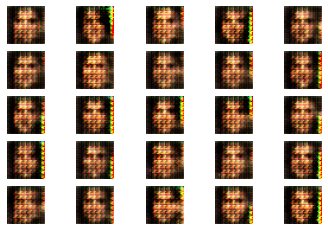

epoch:1 | iter : 800 / 2896 | time : 0:01:45.740478 | g_loss : 0.3030479848384857 | d_loss : [0.83372495 0.1171875 ] 
epoch:1 | iter : 810 / 2896 | time : 0:01:46.918849 | g_loss : 0.2948794960975647 | d_loss : [0.51341721 0.5       ] 
epoch:1 | iter : 820 / 2896 | time : 0:01:48.068822 | g_loss : 0.03527334704995155 | d_loss : [0.36999778 0.5       ] 
epoch:1 | iter : 830 / 2896 | time : 0:01:49.199495 | g_loss : 0.016509346663951874 | d_loss : [0.30385968 0.5       ] 
epoch:1 | iter : 840 / 2896 | time : 0:01:50.345404 | g_loss : 0.01483946479856968 | d_loss : [0.27231764 0.5       ] 
epoch:1 | iter : 850 / 2896 | time : 0:01:51.495607 | g_loss : 0.01085667870938778 | d_loss : [0.28829331 0.5       ] 
epoch:1 | iter : 860 / 2896 | time : 0:01:52.656875 | g_loss : 0.010278277099132538 | d_loss : [0.30486435 0.5       ] 
epoch:1 | iter : 870 / 2896 | time : 0:01:53.812053 | g_loss : 0.01850922778248787 | d_loss : [0.30124448 0.5       ] 
epoch:1 | iter : 880 / 2896 | time : 0:01:54.974

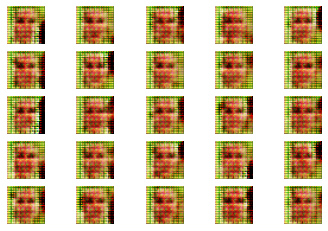

epoch:1 | iter : 900 / 2896 | time : 0:01:58.176058 | g_loss : 0.018226223066449165 | d_loss : [0.32619102 0.5       ] 
epoch:1 | iter : 910 / 2896 | time : 0:01:59.268916 | g_loss : 0.022852160036563873 | d_loss : [0.29635161 0.5       ] 
epoch:1 | iter : 920 / 2896 | time : 0:02:00.358224 | g_loss : 0.0633976012468338 | d_loss : [0.36037844 0.5       ] 
epoch:1 | iter : 930 / 2896 | time : 0:02:01.443444 | g_loss : 0.3182646930217743 | d_loss : [1.05347273 0.0078125 ] 
epoch:1 | iter : 940 / 2896 | time : 0:02:02.542400 | g_loss : 0.0705944150686264 | d_loss : [0.66000266 0.453125  ] 
epoch:1 | iter : 950 / 2896 | time : 0:02:03.633013 | g_loss : 0.033368028700351715 | d_loss : [0.62467717 0.46875   ] 
epoch:1 | iter : 960 / 2896 | time : 0:02:04.731980 | g_loss : 0.034068673849105835 | d_loss : [0.51117142 0.46875   ] 
epoch:1 | iter : 970 / 2896 | time : 0:02:05.840784 | g_loss : 0.28863877058029175 | d_loss : [0.37957194 0.5       ] 
epoch:1 | iter : 980 / 2896 | time : 0:02:06.92

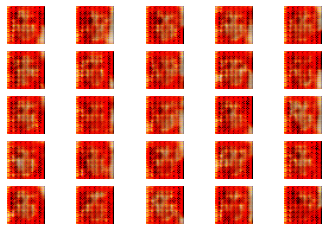

epoch:1 | iter : 1000 / 2896 | time : 0:02:09.961745 | g_loss : 0.014007101766765118 | d_loss : [0.34621522 0.5       ] 
epoch:1 | iter : 1010 / 2896 | time : 0:02:11.065197 | g_loss : 0.007875838316977024 | d_loss : [0.33467315 0.5       ] 
epoch:1 | iter : 1020 / 2896 | time : 0:02:12.155166 | g_loss : 0.006173891015350819 | d_loss : [0.34675545 0.5       ] 
epoch:1 | iter : 1030 / 2896 | time : 0:02:13.253203 | g_loss : 0.010639123618602753 | d_loss : [0.34185113 0.4921875 ] 
epoch:1 | iter : 1040 / 2896 | time : 0:02:14.341080 | g_loss : 0.06286412477493286 | d_loss : [0.41165151 0.46875   ] 
epoch:1 | iter : 1050 / 2896 | time : 0:02:15.451210 | g_loss : 0.8661277890205383 | d_loss : [0.56172571 0.453125  ] 
epoch:1 | iter : 1060 / 2896 | time : 0:02:16.538519 | g_loss : 0.041561562567949295 | d_loss : [0.42054434 0.5       ] 
epoch:1 | iter : 1070 / 2896 | time : 0:02:17.631394 | g_loss : 0.008062896318733692 | d_loss : [0.35017227 0.5       ] 
epoch:1 | iter : 1080 / 2896 | time

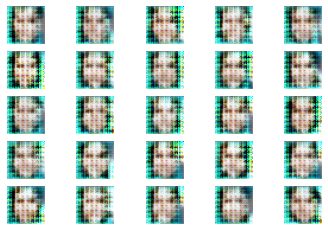

epoch:1 | iter : 1100 / 2896 | time : 0:02:21.667993 | g_loss : 0.007765488233417273 | d_loss : [0.34605256 0.5       ] 
epoch:1 | iter : 1110 / 2896 | time : 0:02:22.797061 | g_loss : 0.014024531468749046 | d_loss : [0.33210693 0.5       ] 
epoch:1 | iter : 1120 / 2896 | time : 0:02:23.914554 | g_loss : 0.022532224655151367 | d_loss : [0.35563659 0.4921875 ] 
epoch:1 | iter : 1130 / 2896 | time : 0:02:25.039668 | g_loss : 0.04507077485322952 | d_loss : [0.32895692 0.5       ] 
epoch:1 | iter : 1140 / 2896 | time : 0:02:26.165580 | g_loss : 0.11357191205024719 | d_loss : [0.40408933 0.484375  ] 
epoch:1 | iter : 1150 / 2896 | time : 0:02:27.333814 | g_loss : 0.1236548125743866 | d_loss : [0.49556431 0.484375  ] 
epoch:1 | iter : 1160 / 2896 | time : 0:02:28.468901 | g_loss : 0.039908114820718765 | d_loss : [0.28259932 0.5       ] 
epoch:1 | iter : 1170 / 2896 | time : 0:02:29.611585 | g_loss : 0.05624403804540634 | d_loss : [0.27785841 0.5       ] 
epoch:1 | iter : 1180 / 2896 | time :

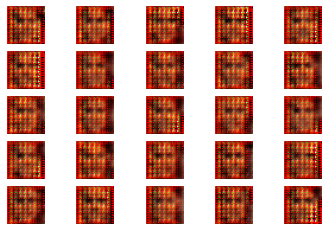

epoch:1 | iter : 1200 / 2896 | time : 0:02:34.012545 | g_loss : 1.3196601867675781 | d_loss : [0.61224392 0.5       ] 
epoch:1 | iter : 1210 / 2896 | time : 0:02:35.110525 | g_loss : 0.046172719448804855 | d_loss : [0.59230625 0.5       ] 
epoch:1 | iter : 1220 / 2896 | time : 0:02:36.206919 | g_loss : 0.004644519649446011 | d_loss : [0.35716663 0.5       ] 
epoch:1 | iter : 1230 / 2896 | time : 0:02:37.299799 | g_loss : 0.002591749420389533 | d_loss : [0.30700605 0.5       ] 
epoch:1 | iter : 1240 / 2896 | time : 0:02:38.384822 | g_loss : 0.0060627879574894905 | d_loss : [0.2860103 0.5      ] 
epoch:1 | iter : 1250 / 2896 | time : 0:02:39.476694 | g_loss : 0.01723995804786682 | d_loss : [0.29700332 0.5       ] 
epoch:1 | iter : 1260 / 2896 | time : 0:02:40.576623 | g_loss : 0.05064309760928154 | d_loss : [0.28710228 0.5       ] 
epoch:1 | iter : 1270 / 2896 | time : 0:02:41.681145 | g_loss : 0.14026857912540436 | d_loss : [0.3164171 0.5      ] 
epoch:1 | iter : 1280 / 2896 | time : 0:

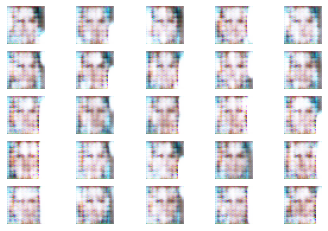

epoch:1 | iter : 1300 / 2896 | time : 0:02:45.854706 | g_loss : 0.048616230487823486 | d_loss : [0.34605461 0.5       ] 
epoch:1 | iter : 1310 / 2896 | time : 0:02:46.969384 | g_loss : 0.012659388594329357 | d_loss : [0.3291454 0.5      ] 
epoch:1 | iter : 1320 / 2896 | time : 0:02:48.054412 | g_loss : 0.008938604965806007 | d_loss : [0.372023  0.4921875] 
epoch:1 | iter : 1330 / 2896 | time : 0:02:49.156243 | g_loss : 0.011347206309437752 | d_loss : [0.46018101 0.46875   ] 
epoch:1 | iter : 1340 / 2896 | time : 0:02:50.243418 | g_loss : 0.03924805670976639 | d_loss : [0.67745945 0.3671875 ] 
epoch:1 | iter : 1350 / 2896 | time : 0:02:51.337527 | g_loss : 0.38358789682388306 | d_loss : [0.6550014 0.390625 ] 
epoch:1 | iter : 1360 / 2896 | time : 0:02:52.433693 | g_loss : 0.5252206325531006 | d_loss : [0.65714937 0.421875  ] 
epoch:1 | iter : 1370 / 2896 | time : 0:02:53.559245 | g_loss : 0.5611271858215332 | d_loss : [0.71917081 0.1875    ] 
epoch:1 | iter : 1380 / 2896 | time : 0:02:5

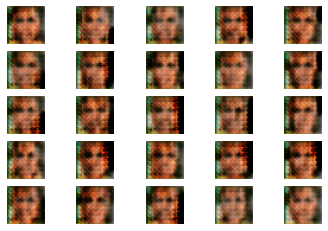

epoch:1 | iter : 1400 / 2896 | time : 0:02:57.635013 | g_loss : 0.007057229056954384 | d_loss : [0.4659868 0.5      ] 
epoch:1 | iter : 1410 / 2896 | time : 0:02:58.789536 | g_loss : 0.002366838976740837 | d_loss : [0.46508263 0.5       ] 
epoch:1 | iter : 1420 / 2896 | time : 0:02:59.927035 | g_loss : 0.002399633638560772 | d_loss : [0.51215287 0.484375  ] 
epoch:1 | iter : 1430 / 2896 | time : 0:03:01.079054 | g_loss : 0.012426656670868397 | d_loss : [0.50378874 0.4921875 ] 
epoch:1 | iter : 1440 / 2896 | time : 0:03:02.232708 | g_loss : 0.07722827047109604 | d_loss : [0.52467205 0.4765625 ] 
epoch:1 | iter : 1450 / 2896 | time : 0:03:03.374572 | g_loss : 0.08033449947834015 | d_loss : [0.45951194 0.5       ] 
epoch:1 | iter : 1460 / 2896 | time : 0:03:04.547724 | g_loss : 0.06332647800445557 | d_loss : [0.58629121 0.4609375 ] 
epoch:1 | iter : 1470 / 2896 | time : 0:03:05.707764 | g_loss : 0.1825805902481079 | d_loss : [0.50653756 0.4765625 ] 
epoch:1 | iter : 1480 / 2896 | time : 0

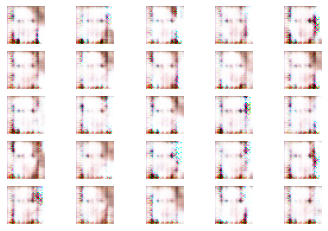

epoch:1 | iter : 1500 / 2896 | time : 0:03:10.080349 | g_loss : 0.006229330785572529 | d_loss : [0.28089638 0.5       ] 
epoch:1 | iter : 1510 / 2896 | time : 0:03:11.184064 | g_loss : 0.003970742225646973 | d_loss : [0.28059663 0.5       ] 
epoch:1 | iter : 1520 / 2896 | time : 0:03:12.279437 | g_loss : 0.0025805062614381313 | d_loss : [0.27649471 0.5       ] 
epoch:1 | iter : 1530 / 2896 | time : 0:03:13.388739 | g_loss : 0.0017480801325291395 | d_loss : [0.30053512 0.5       ] 
epoch:1 | iter : 1540 / 2896 | time : 0:03:14.476491 | g_loss : 0.0024599009193480015 | d_loss : [0.32817198 0.5       ] 
epoch:1 | iter : 1550 / 2896 | time : 0:03:15.573617 | g_loss : 0.003937099128961563 | d_loss : [0.47728004 0.5       ] 
epoch:1 | iter : 1560 / 2896 | time : 0:03:16.660018 | g_loss : 0.014568133279681206 | d_loss : [0.68631089 0.3671875 ] 
epoch:1 | iter : 1570 / 2896 | time : 0:03:17.763806 | g_loss : 0.7640982866287231 | d_loss : [0.59017681 0.4765625 ] 
epoch:1 | iter : 1580 / 2896 | 

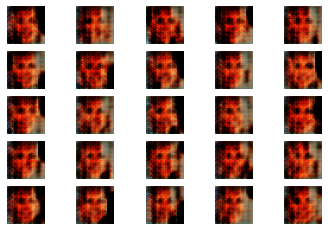

epoch:1 | iter : 1600 / 2896 | time : 0:03:21.909109 | g_loss : 0.023467987775802612 | d_loss : [0.41490012 0.5       ] 
epoch:1 | iter : 1610 / 2896 | time : 0:03:23.032748 | g_loss : 0.007523323409259319 | d_loss : [0.34570599 0.5       ] 
epoch:1 | iter : 1620 / 2896 | time : 0:03:24.135335 | g_loss : 0.00347337918356061 | d_loss : [0.32013936 0.5       ] 
epoch:1 | iter : 1630 / 2896 | time : 0:03:25.223046 | g_loss : 0.0029108684975653887 | d_loss : [0.33944876 0.5       ] 
epoch:1 | iter : 1640 / 2896 | time : 0:03:26.308152 | g_loss : 0.0037679686211049557 | d_loss : [0.42043664 0.4765625 ] 
epoch:1 | iter : 1650 / 2896 | time : 0:03:27.412205 | g_loss : 0.007242198102176189 | d_loss : [0.38898702 0.4765625 ] 
epoch:1 | iter : 1660 / 2896 | time : 0:03:28.497657 | g_loss : 0.02447405457496643 | d_loss : [0.40978222 0.484375  ] 
epoch:1 | iter : 1670 / 2896 | time : 0:03:29.597530 | g_loss : 0.06606584787368774 | d_loss : [0.40988753 0.5       ] 
epoch:1 | iter : 1680 / 2896 | ti

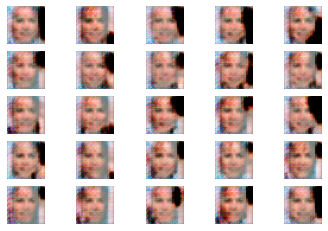

epoch:1 | iter : 1700 / 2896 | time : 0:03:33.626411 | g_loss : 0.19091150164604187 | d_loss : [0.52865078 0.4765625 ] 
epoch:1 | iter : 1710 / 2896 | time : 0:03:34.841712 | g_loss : 0.268426775932312 | d_loss : [0.93764889 0.0234375 ] 
epoch:1 | iter : 1720 / 2896 | time : 0:03:36.007234 | g_loss : 0.040644627064466476 | d_loss : [0.48778215 0.5       ] 
epoch:1 | iter : 1730 / 2896 | time : 0:03:37.148406 | g_loss : 0.008641229011118412 | d_loss : [0.32765924 0.5       ] 
epoch:1 | iter : 1740 / 2896 | time : 0:03:38.330234 | g_loss : 0.004391823895275593 | d_loss : [0.34860329 0.5       ] 
epoch:1 | iter : 1750 / 2896 | time : 0:03:39.479566 | g_loss : 0.002911715768277645 | d_loss : [0.36162026 0.5       ] 
epoch:1 | iter : 1760 / 2896 | time : 0:03:40.617968 | g_loss : 0.0030199987813830376 | d_loss : [0.39488024 0.4921875 ] 
epoch:1 | iter : 1770 / 2896 | time : 0:03:41.751578 | g_loss : 0.004811355844140053 | d_loss : [0.48913407 0.4921875 ] 
epoch:1 | iter : 1780 / 2896 | time

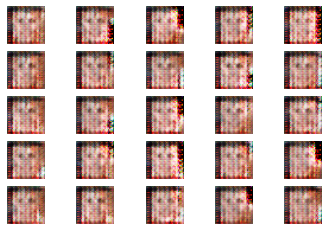

epoch:1 | iter : 1800 / 2896 | time : 0:03:46.104744 | g_loss : 0.13230100274085999 | d_loss : [0.60120067 0.3984375 ] 
epoch:1 | iter : 1810 / 2896 | time : 0:03:47.205381 | g_loss : 0.1078185886144638 | d_loss : [0.56892194 0.4296875 ] 
epoch:1 | iter : 1820 / 2896 | time : 0:03:48.289488 | g_loss : 0.6521480083465576 | d_loss : [0.55029944 0.4609375 ] 
epoch:1 | iter : 1830 / 2896 | time : 0:03:49.369330 | g_loss : 0.3296152949333191 | d_loss : [0.95027775 0.        ] 
epoch:1 | iter : 1840 / 2896 | time : 0:03:50.456379 | g_loss : 0.19047485291957855 | d_loss : [0.98993826 0.1796875 ] 
epoch:1 | iter : 1850 / 2896 | time : 0:03:51.539545 | g_loss : 0.027484489604830742 | d_loss : [0.62676978 0.5       ] 
epoch:1 | iter : 1860 / 2896 | time : 0:03:52.633865 | g_loss : 0.016224563121795654 | d_loss : [0.54216126 0.4921875 ] 
epoch:1 | iter : 1870 / 2896 | time : 0:03:53.711280 | g_loss : 0.024329818785190582 | d_loss : [0.60714027 0.4609375 ] 
epoch:1 | iter : 1880 / 2896 | time : 0:

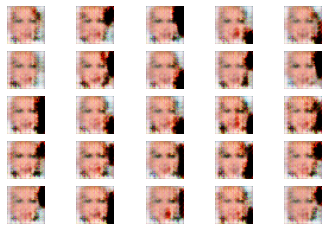

epoch:1 | iter : 1900 / 2896 | time : 0:03:57.835964 | g_loss : 0.841321587562561 | d_loss : [0.51558733 0.4765625 ] 
epoch:1 | iter : 1910 / 2896 | time : 0:03:58.937563 | g_loss : 0.09361417591571808 | d_loss : [0.57808761 0.5       ] 
epoch:1 | iter : 1920 / 2896 | time : 0:04:00.008985 | g_loss : 0.05882517993450165 | d_loss : [0.72621661 0.375     ] 
epoch:1 | iter : 1930 / 2896 | time : 0:04:01.077891 | g_loss : 0.23077967762947083 | d_loss : [0.63139555 0.4296875 ] 
epoch:1 | iter : 1940 / 2896 | time : 0:04:02.143166 | g_loss : 0.14221948385238647 | d_loss : [0.5264844 0.4921875] 
epoch:1 | iter : 1950 / 2896 | time : 0:04:03.230679 | g_loss : 0.0675722062587738 | d_loss : [0.44966921 0.5       ] 
epoch:1 | iter : 1960 / 2896 | time : 0:04:04.321756 | g_loss : 0.08032259345054626 | d_loss : [0.47685346 0.5       ] 
epoch:1 | iter : 1970 / 2896 | time : 0:04:05.424589 | g_loss : 0.30046385526657104 | d_loss : [0.54742087 0.4765625 ] 
epoch:1 | iter : 1980 / 2896 | time : 0:04:06

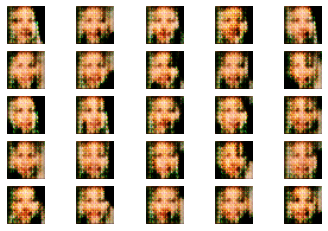

epoch:1 | iter : 2000 / 2896 | time : 0:04:09.426980 | g_loss : 0.05337494611740112 | d_loss : [0.60001771 0.4765625 ] 
epoch:1 | iter : 2010 / 2896 | time : 0:04:10.547941 | g_loss : 0.027317684143781662 | d_loss : [0.51941398 0.5       ] 
epoch:1 | iter : 2020 / 2896 | time : 0:04:11.668336 | g_loss : 0.03417680412530899 | d_loss : [0.51041929 0.484375  ] 
epoch:1 | iter : 2030 / 2896 | time : 0:04:12.797342 | g_loss : 0.04305413365364075 | d_loss : [0.52664223 0.4765625 ] 
epoch:1 | iter : 2040 / 2896 | time : 0:04:13.943056 | g_loss : 0.07260790467262268 | d_loss : [0.49635527 0.484375  ] 
epoch:1 | iter : 2050 / 2896 | time : 0:04:15.090289 | g_loss : 0.2283916473388672 | d_loss : [0.49681622 0.5       ] 
epoch:1 | iter : 2060 / 2896 | time : 0:04:16.225893 | g_loss : 0.3403754234313965 | d_loss : [0.61813799 0.4140625 ] 
epoch:1 | iter : 2070 / 2896 | time : 0:04:17.361410 | g_loss : 0.435366153717041 | d_loss : [0.92550042 0.015625  ] 
epoch:1 | iter : 2080 / 2896 | time : 0:04:

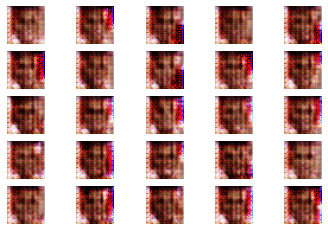

epoch:1 | iter : 2100 / 2896 | time : 0:04:21.680560 | g_loss : 0.17229385673999786 | d_loss : [0.68644094 0.3984375 ] 
epoch:1 | iter : 2110 / 2896 | time : 0:04:22.785451 | g_loss : 0.28839558362960815 | d_loss : [0.46773246 0.5       ] 
epoch:1 | iter : 2120 / 2896 | time : 0:04:23.856965 | g_loss : 0.24094587564468384 | d_loss : [0.46996206 0.5       ] 
epoch:1 | iter : 2130 / 2896 | time : 0:04:24.949326 | g_loss : 0.13896344602108002 | d_loss : [0.5299435 0.484375 ] 
epoch:1 | iter : 2140 / 2896 | time : 0:04:26.063769 | g_loss : 0.15513457357883453 | d_loss : [0.52823997 0.3984375 ] 
epoch:1 | iter : 2150 / 2896 | time : 0:04:27.158244 | g_loss : 0.2582513988018036 | d_loss : [0.54214582 0.390625  ] 
epoch:1 | iter : 2160 / 2896 | time : 0:04:28.236624 | g_loss : 0.7253203392028809 | d_loss : [0.70428708 0.15625   ] 
epoch:1 | iter : 2170 / 2896 | time : 0:04:29.346294 | g_loss : 0.6155840158462524 | d_loss : [0.82737833 0.3046875 ] 
epoch:1 | iter : 2180 / 2896 | time : 0:04:30

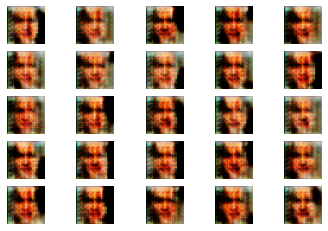

epoch:1 | iter : 2200 / 2896 | time : 0:04:33.526301 | g_loss : 0.0029729462694376707 | d_loss : [0.46775848 0.5       ] 
epoch:1 | iter : 2210 / 2896 | time : 0:04:34.666211 | g_loss : 0.0019726098980754614 | d_loss : [0.5478919 0.484375 ] 
epoch:1 | iter : 2220 / 2896 | time : 0:04:35.758771 | g_loss : 0.0035160006955266 | d_loss : [0.56277107 0.4609375 ] 
epoch:1 | iter : 2230 / 2896 | time : 0:04:36.839037 | g_loss : 0.016174286603927612 | d_loss : [0.54851991 0.4296875 ] 
epoch:1 | iter : 2240 / 2896 | time : 0:04:37.927902 | g_loss : 0.13989976048469543 | d_loss : [0.47044712 0.4921875 ] 
epoch:1 | iter : 2250 / 2896 | time : 0:04:39.014012 | g_loss : 0.3386693000793457 | d_loss : [0.57018614 0.4375    ] 
epoch:1 | iter : 2260 / 2896 | time : 0:04:40.117068 | g_loss : 0.4946107864379883 | d_loss : [0.68623534 0.484375  ] 
epoch:1 | iter : 2270 / 2896 | time : 0:04:41.213520 | g_loss : 0.038910530507564545 | d_loss : [0.64207298 0.4921875 ] 
epoch:1 | iter : 2280 / 2896 | time : 0

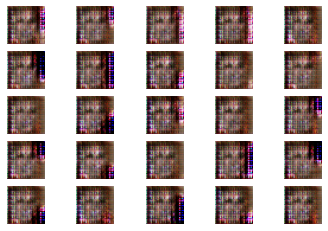

epoch:1 | iter : 2300 / 2896 | time : 0:04:45.247249 | g_loss : 0.38575172424316406 | d_loss : [0.45114453 0.5       ] 
epoch:1 | iter : 2310 / 2896 | time : 0:04:46.382984 | g_loss : 0.5481425523757935 | d_loss : [0.53687173 0.4609375 ] 
epoch:1 | iter : 2320 / 2896 | time : 0:04:47.498851 | g_loss : 0.8277415633201599 | d_loss : [0.75370684 0.21875   ] 
epoch:1 | iter : 2330 / 2896 | time : 0:04:48.623585 | g_loss : 0.19977279007434845 | d_loss : [0.70717414 0.4921875 ] 
epoch:1 | iter : 2340 / 2896 | time : 0:04:49.745312 | g_loss : 0.06658796966075897 | d_loss : [0.59716859 0.5       ] 
epoch:1 | iter : 2350 / 2896 | time : 0:04:50.872038 | g_loss : 0.024008017033338547 | d_loss : [0.44059825 0.5       ] 
epoch:1 | iter : 2360 / 2896 | time : 0:04:51.997388 | g_loss : 0.010580997914075851 | d_loss : [0.43957351 0.5       ] 
epoch:1 | iter : 2370 / 2896 | time : 0:04:53.128064 | g_loss : 0.01244039461016655 | d_loss : [0.42445838 0.5       ] 
epoch:1 | iter : 2380 / 2896 | time : 0:

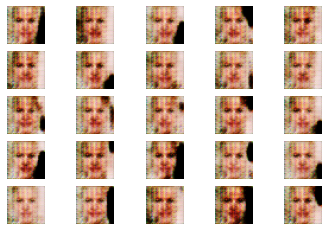

epoch:1 | iter : 2400 / 2896 | time : 0:04:57.490714 | g_loss : 0.08471929281949997 | d_loss : [0.47060513 0.5       ] 
epoch:1 | iter : 2410 / 2896 | time : 0:04:58.581445 | g_loss : 0.15249623358249664 | d_loss : [0.54764394 0.4140625 ] 
epoch:1 | iter : 2420 / 2896 | time : 0:04:59.654902 | g_loss : 1.2368779182434082 | d_loss : [0.68676472 0.3359375 ] 
epoch:1 | iter : 2430 / 2896 | time : 0:05:00.751526 | g_loss : 0.10273782163858414 | d_loss : [1.07398254 0.09375   ] 
epoch:1 | iter : 2440 / 2896 | time : 0:05:01.843067 | g_loss : 0.46233290433883667 | d_loss : [0.40318932 0.5       ] 
epoch:1 | iter : 2450 / 2896 | time : 0:05:02.938310 | g_loss : 0.2643968462944031 | d_loss : [0.34364366 0.5       ] 
epoch:1 | iter : 2460 / 2896 | time : 0:05:04.029334 | g_loss : 0.27021294832229614 | d_loss : [0.45347029 0.4921875 ] 
epoch:1 | iter : 2470 / 2896 | time : 0:05:05.129728 | g_loss : 0.8197851181030273 | d_loss : [0.57880619 0.5       ] 
epoch:1 | iter : 2480 / 2896 | time : 0:05:

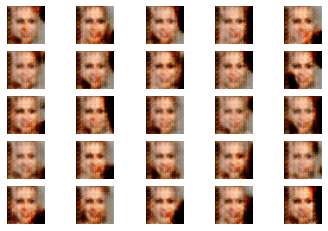

epoch:1 | iter : 2500 / 2896 | time : 0:05:09.329835 | g_loss : 0.7365350723266602 | d_loss : [0.76229459 0.390625  ] 
epoch:1 | iter : 2510 / 2896 | time : 0:05:10.449082 | g_loss : 0.28989720344543457 | d_loss : [0.71737029 0.4453125 ] 
epoch:1 | iter : 2520 / 2896 | time : 0:05:11.536480 | g_loss : 0.029512299224734306 | d_loss : [0.65414007 0.4375    ] 
epoch:1 | iter : 2530 / 2896 | time : 0:05:12.631476 | g_loss : 0.06488637626171112 | d_loss : [0.69546694 0.296875  ] 
epoch:1 | iter : 2540 / 2896 | time : 0:05:13.724788 | g_loss : 0.3273710608482361 | d_loss : [0.49828961 0.4921875 ] 
epoch:1 | iter : 2550 / 2896 | time : 0:05:14.807320 | g_loss : 0.6329171657562256 | d_loss : [0.55914465 0.484375  ] 
epoch:1 | iter : 2560 / 2896 | time : 0:05:15.912584 | g_loss : 0.4115433096885681 | d_loss : [0.8478002 0.03125  ] 
epoch:1 | iter : 2570 / 2896 | time : 0:05:17.000518 | g_loss : 0.3210027813911438 | d_loss : [0.86278361 0.109375  ] 
epoch:1 | iter : 2580 / 2896 | time : 0:05:18.

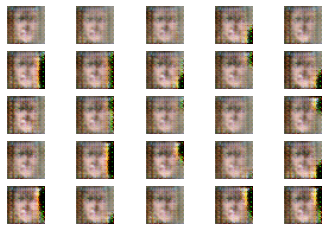

epoch:1 | iter : 2600 / 2896 | time : 0:05:21.025011 | g_loss : 0.25054293870925903 | d_loss : [0.56638196 0.4921875 ] 
epoch:1 | iter : 2610 / 2896 | time : 0:05:22.163753 | g_loss : 0.21809989213943481 | d_loss : [0.55458137 0.5       ] 
epoch:1 | iter : 2620 / 2896 | time : 0:05:23.286735 | g_loss : 0.4468158483505249 | d_loss : [0.57157558 0.4765625 ] 
epoch:1 | iter : 2630 / 2896 | time : 0:05:24.409800 | g_loss : 0.43054965138435364 | d_loss : [0.62730196 0.484375  ] 
epoch:1 | iter : 2640 / 2896 | time : 0:05:25.549983 | g_loss : 0.3071404695510864 | d_loss : [0.79206073 0.0078125 ] 
epoch:1 | iter : 2650 / 2896 | time : 0:05:26.672367 | g_loss : 0.3162352740764618 | d_loss : [0.67974624 0.3125    ] 
epoch:1 | iter : 2660 / 2896 | time : 0:05:27.822819 | g_loss : 0.28966212272644043 | d_loss : [0.65743488 0.453125  ] 
epoch:1 | iter : 2670 / 2896 | time : 0:05:28.950824 | g_loss : 0.2953845262527466 | d_loss : [0.6489113 0.484375 ] 
epoch:1 | iter : 2680 / 2896 | time : 0:05:30.

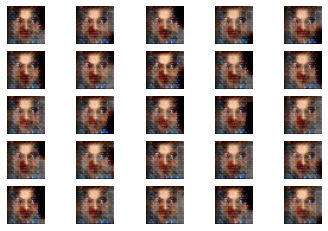

epoch:1 | iter : 2700 / 2896 | time : 0:05:33.315748 | g_loss : 0.9759674072265625 | d_loss : [0.6430192 0.4921875] 
epoch:1 | iter : 2710 / 2896 | time : 0:05:34.424027 | g_loss : 0.004231310449540615 | d_loss : [0.54229546 0.4765625 ] 
epoch:1 | iter : 2720 / 2896 | time : 0:05:35.544529 | g_loss : 0.004681638441979885 | d_loss : [0.46596318 0.5       ] 
epoch:1 | iter : 2730 / 2896 | time : 0:05:36.657390 | g_loss : 0.004847310483455658 | d_loss : [0.41654348 0.4921875 ] 
epoch:1 | iter : 2740 / 2896 | time : 0:05:37.780210 | g_loss : 0.006921663880348206 | d_loss : [0.42535329 0.5       ] 
epoch:1 | iter : 2750 / 2896 | time : 0:05:38.910174 | g_loss : 0.01012209989130497 | d_loss : [0.34428955 0.5       ] 
epoch:1 | iter : 2760 / 2896 | time : 0:05:40.043450 | g_loss : 0.017648868262767792 | d_loss : [0.28796703 0.5       ] 
epoch:1 | iter : 2770 / 2896 | time : 0:05:41.185532 | g_loss : 0.02384749986231327 | d_loss : [0.32197681 0.5       ] 
epoch:1 | iter : 2780 / 2896 | time : 

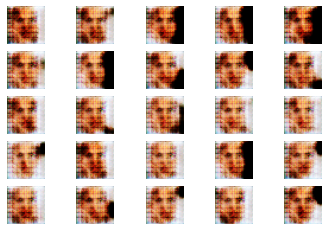

epoch:1 | iter : 2800 / 2896 | time : 0:05:45.464991 | g_loss : 0.156079962849617 | d_loss : [0.33747983 0.4921875 ] 
epoch:1 | iter : 2810 / 2896 | time : 0:05:46.582625 | g_loss : 0.27747708559036255 | d_loss : [0.89011624 0.0625    ] 
epoch:1 | iter : 2820 / 2896 | time : 0:05:47.684680 | g_loss : 0.03529823571443558 | d_loss : [0.47964493 0.4921875 ] 
epoch:1 | iter : 2830 / 2896 | time : 0:05:48.778384 | g_loss : 0.017625393345952034 | d_loss : [0.45535421 0.5       ] 
epoch:1 | iter : 2840 / 2896 | time : 0:05:49.873371 | g_loss : 0.01692625880241394 | d_loss : [0.53551367 0.5       ] 
epoch:1 | iter : 2850 / 2896 | time : 0:05:50.964306 | g_loss : 0.03568065166473389 | d_loss : [0.68900618 0.4609375 ] 
epoch:1 | iter : 2860 / 2896 | time : 0:05:52.074297 | g_loss : 0.06340102851390839 | d_loss : [0.61536276 0.5       ] 
epoch:1 | iter : 2870 / 2896 | time : 0:05:53.154273 | g_loss : 0.06950022280216217 | d_loss : [0.61317781 0.4921875 ] 
epoch:1 | iter : 2880 / 2896 | time : 0:0

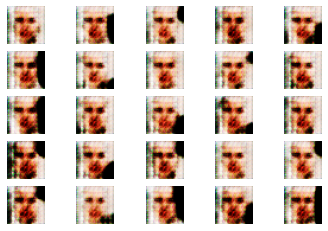

epoch:2 | iter : 100 / 2896 | time : 0:06:07.681445 | g_loss : 0.06626028567552567 | d_loss : [0.28193103 0.5       ] 
epoch:2 | iter : 110 / 2896 | time : 0:06:08.835051 | g_loss : 0.18804261088371277 | d_loss : [0.33729368 0.4609375 ] 
epoch:2 | iter : 120 / 2896 | time : 0:06:09.982849 | g_loss : 0.7444156408309937 | d_loss : [0.79031712 0.09375   ] 
epoch:2 | iter : 130 / 2896 | time : 0:06:11.141391 | g_loss : 0.1295793056488037 | d_loss : [0.75782099 0.4921875 ] 
epoch:2 | iter : 140 / 2896 | time : 0:06:12.293536 | g_loss : 0.05672736093401909 | d_loss : [0.42562923 0.5       ] 
epoch:2 | iter : 150 / 2896 | time : 0:06:13.435278 | g_loss : 0.08036947250366211 | d_loss : [0.41226998 0.5       ] 


KeyboardInterrupt: ignored

In [9]:
gan = DCGAN()
DEBUG = 0

if DEBUG == 1:
    gan.n_data = 50
    gan.train(epochs=1, batch_size=1, sample_interval=10)
else:
    gan.train(epochs=20, batch_size=64, sample_interval=100)